In [1]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Write prospect theory model

In [2]:
# We want to transform an objective value X into a subjective utility U
def prospect_utility(x, lam, rho):
    if x >= 0:
        u = x**rho
    elif x < 0:
        u = -lam*(-x)**rho
    return u

## Simulate one parameter setting

In [3]:
lam = 2
rho = .8

In [4]:
xs = np.arange(-10, 11, .1)
us = np.array([prospect_utility(x, lam, rho) for x in xs])

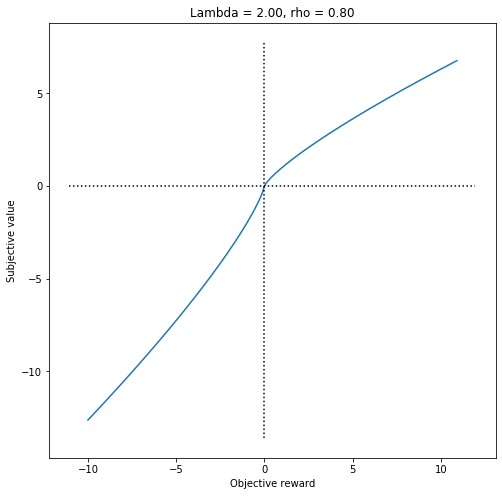

In [5]:
fig, axes = plt.subplots(1,1,figsize=[8,8]);
axes.plot(xs, us);
axes.plot([0,0], axes.get_ylim(), 'k:');
axes.plot(axes.get_xlim(), [0,0], 'k:');
axes.set(xlabel = 'Objective reward', ylabel = 'Subjective value', title = 'Lambda = %.2f, rho = %.2f'%(lam,rho));

## Simulate a bunch of parameter values

In [6]:
lambdas = [1,2,3]
rhos = [0.5,1,1.5]

In [7]:
all_us = pd.DataFrame()
for lam in lambdas:
    for rho in rhos:
        for x in xs:
            u = prospect_utility(x, lam, rho)
            all_us = all_us.append(pd.DataFrame([[lam,rho,x,u]],columns = ['lambda','rho','x','u']))
all_us = all_us.reset_index(drop=True)

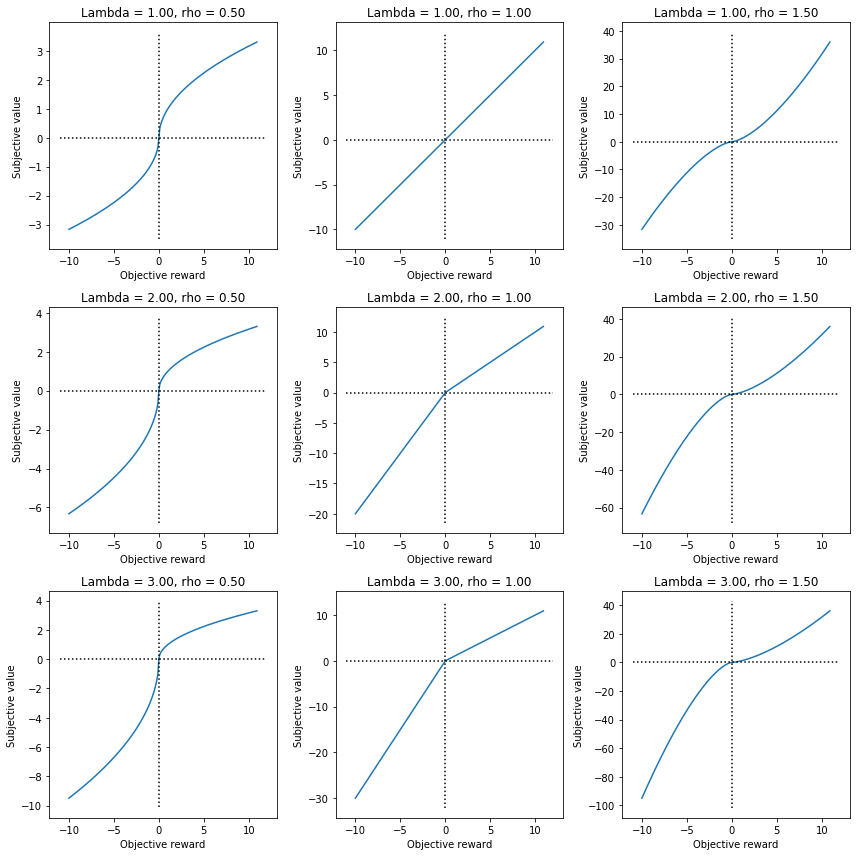

In [8]:
nrows = len(lambdas)
ncols = len(rhos)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = [nrows*4,ncols*4])
for li,lam in enumerate(lambdas):
    for ri,rho in enumerate(rhos):
        sim_dat = all_us.loc[(all_us['lambda']==lam) & (all_us['rho']==rho),['x','u']]
        xs = sim_dat['x']
        us = sim_dat['u']
        ax = axes[li,ri]
        ax.plot(xs, us);
        ax.plot([0,0], ax.get_ylim(), 'k:');
        ax.plot(ax.get_xlim(), [0,0], 'k:');
        ax.set(xlabel = 'Objective reward', ylabel = 'Subjective value',
               title = 'Lambda = %.2f, rho = %.2f'%(lam,rho));
plt.tight_layout()

## Let's do some gambles and fit the curve

In [97]:
dat = pd.read_csv('Data/prospect_theory/pt_replication.csv').dropna()
dat.head()

,sub,gamble_number,choice,choice_label,trial,value_A,value_B,prob_A,prob_B,ev_A,ev_B
0,1,4,1.0,A,1,4000,3000,0.2,0.25,800,750.0
1,1,6,1.0,A,2,6000,3000,1E-3,2E-3,6,6.0
2,1,2,0.0,B,3,2500,2400,0.33,0.34,825,816.0
3,1,3,0.0,B,4,4000,3000,0.8,1,3200,3000.0
4,1,17,0.0,B,5,-5000,-5,1E-3,1,-5,-5.0


In [98]:
# Data types
dtypes = {'sub':int, 'gamble_number':int, 'choice':int, 'trial':int}
for col in dtypes.keys():
    dat[col] = dat[col].astype(dtypes[col])

In [99]:
# Split options A and B by their multiple outcomes
columns_to_split = ['value_A','value_B','prob_A','prob_B']
split_cols = []
for col in columns_to_split:
    col_out_1, col_out_2 = ['%s1'%col,'%s2'%col]
    split_cols.extend([col_out_1,col_out_2])
    print(col_out_1, col_out_2)
    dat[[col_out_1, col_out_2]] = dat[col].str.split(pat = ', ', expand=True).copy()
# dat = dat.drop(columns = columns_to_split)
dat = dat.replace(to_replace = {None:0})
dat.head()

value_A1 value_A2
value_B1 value_B2
prob_A1 prob_A2
prob_B1 prob_B2


,sub,gamble_number,choice,choice_label,trial,value_A,value_B,prob_A,prob_B,ev_A,ev_B,value_A1,value_A2,value_B1,value_B2,prob_A1,prob_A2,prob_B1,prob_B2
0,1,4,1,A,1,4000,3000,0.2,0.25,800,750.0,4000,0,3000,0,0.2,0,0.25,0
1,1,6,1,A,2,6000,3000,1E-3,2E-3,6,6.0,6000,0,3000,0,1E-3,0,2E-3,0
2,1,2,0,B,3,2500,2400,0.33,0.34,825,816.0,2500,0,2400,0,0.33,0,0.34,0
3,1,3,0,B,4,4000,3000,0.8,1,3200,3000.0,4000,0,3000,0,0.8,0,1,0
4,1,17,0,B,5,-5000,-5,1E-3,1,-5,-5.0,-5000,0,-5,0,1E-3,0,1,0


In [100]:
# More dtypes -> all to float
# float_cols = split_cols
# float_cols.extend(columns_to_split)
for col in split_cols:
    dat[col] = dat[col].astype(float)

##### One subject's data

In [101]:
subdat = dat.query('sub == "2"')
subdat.head()

,sub,gamble_number,choice,choice_label,trial,value_A,value_B,prob_A,prob_B,ev_A,ev_B,value_A1,value_A2,value_B1,value_B2,prob_A1,prob_A2,prob_B1,prob_B2
17,2,7,0,B,1,-4000,-3000,0.8,1,-3200,-3000.0,-4000.0,0.0,-3000.0,0.0,0.800,0.0,1.00,0.00
18,2,17,0,B,2,-5000,-5,1E-3,1,-5,-5.0,-5000.0,0.0,-5.0,0.0,0.001,0.0,1.00,0.00
19,2,16,1,A,3,5000,5,1E-3,1,5,5.0,5000.0,0.0,5.0,0.0,0.001,0.0,1.00,0.00
20,2,11,0,B,4,4000,3000,0.2,0.25,800,750.0,4000.0,0.0,3000.0,0.0,0.200,0.0,0.25,0.00
21,2,15,1,A,5,-6000,"-4000, -2000",0.25,"0.25, 0.25",-1500,-1500.0,-6000.0,0.0,-4000.0,-2000.0,0.250,0.0,0.25,0.25


##### Step 1 of model fitting: visualize

In [102]:
gambles = sorted(dat['gamble_number'].unique())
gambles

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

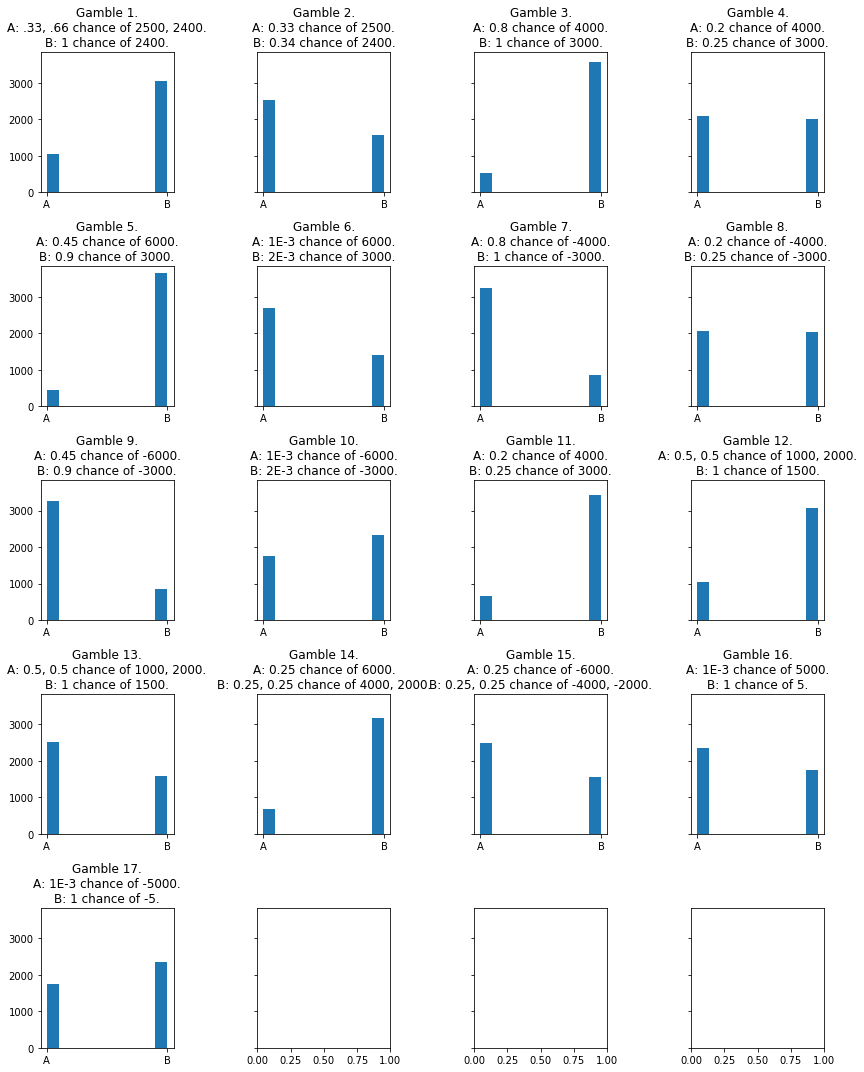

In [114]:
ncols = 4
nrows = int(np.ceil(len(gambles)/ncols))
fig,axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = [3*ncols, 3*nrows], sharey = True)
axes = axes.ravel()
for gi,gamble in enumerate(gambles):
    ax = axes[gi]
    gamble_dat = dat.query('gamble_number == @gamble').sort_values(by=['choice_label'])
    ax.hist(gamble_dat['choice_label'])
    gamble_info = gamble_dat.iloc[0,:].copy()
    ax.set(title = 'Gamble %i.\nA: %s chance of %s.\nB: %s chance of %s.'%(
        gamble,gamble_info['prob_A'],gamble_info['value_A'],gamble_info['prob_B'],gamble_info['value_B']))
plt.tight_layout()

## Model fitting: next steps

1. Write utility model (we already have this).
2. Write softmax choice rule.
3. Predict some behavior (datasets) with some parameters. Try guessing the parameters that might work for your favorite subject.
4. Plot comparison of subject data to simulated data.
5. Fit model to data.